In [1]:
from pyLCIO import IOIMPL
from tqdm.auto import tqdm
from glob import glob
from math import sqrt
import os.path as osp
import matplotlib.pyplot as plt
import numpy as np

Welcome to JupyROOT 6.30/04
Loading LCIO ROOT dictionaries ...


ee ZH mumu

In [16]:
reader = IOIMPL.LCFactory.getInstance().createLCReader()
reader.open(osp.abspath("zh.slcio"))
result = []

for event in (pbar := tqdm(range(reader.getNumberOfEvents()))):
    event = reader.readNextEvent()
    pbar.set_description(f'Processing event {event.getEventNumber()}')

    # Iterate through the MCParticle collection and find muon and anti muon
    # see page 5 on https://pdg.lbl.gov/2019/reviews/rpp2019-rev-monte-carlo-numbering.pdf
    iso_leptons = event.getCollection('ISOLeptons')
    
    E = 0
    pX = 0
    pY = 0
    pZ = 0
    n_muons = 0
    
    for iso_lepton in iso_leptons:
        if abs(iso_lepton.getType()) == 13:
            mom = iso_lepton.getMomentum()
            
            E += iso_lepton.getEnergy()
            pX += mom[0]
            pY += mom[1]
            pZ += mom[2]
            n_muons += 1

    if n_muons == 2:
        result.append([E, pX, pY, pZ])
        
    # break

reader.getNumberOfEvents()

result = np.array(result)

  0%|          | 0/9400 [00:00<?, ?it/s]

In [14]:
reader.getNumberOfEvents()

9400

In [17]:
len(result)

8355

In [18]:
np.save('mumuH_250.npy', result)

ee ZH ee

In [6]:
reader = IOIMPL.LCFactory.getInstance().createLCReader()
reader.open(osp.abspath("zh_epem.slcio"))
result = []

for event in (pbar := tqdm(range(reader.getNumberOfEvents()))):
    event = reader.readNextEvent()
    pbar.set_description(f'Processing event {event.getEventNumber()}')

    # Iterate through the MCParticle collection and find muon and anti muon
    # see page 5 on https://pdg.lbl.gov/2019/reviews/rpp2019-rev-monte-carlo-numbering.pdf
    iso_leptons = event.getCollection('ISOLeptons')
    
    E = 0
    pX = 0
    pY = 0
    pZ = 0
    n_epem = 0
    
    for iso_lepton in iso_leptons:
        if abs(iso_lepton.getType()) == 11:
            mom = iso_lepton.getMomentum()
            
            E += iso_lepton.getEnergy()
            pX += mom[0]
            pY += mom[1]
            pZ += mom[2]
            n_epem += 1

    if n_epem == 2:
        result.append([E, pX, pY, pZ])
        
    # break

reader.getNumberOfEvents()

result = np.array(result)

  0%|          | 0/8400 [00:00<?, ?it/s]

In [7]:
np.save('eeH_250.npy', result)

In [8]:
len(result)

6905

Test (calculate Higgs mass directly)

In [3]:
reader = IOIMPL.LCFactory.getInstance().createLCReader()
reader.open(osp.abspath("zh.slcio"))
result = []

for event in (pbar := tqdm(range(reader.getNumberOfEvents()))):
    event = reader.readNextEvent()
    pbar.set_description(f'Processing event {event.getEventNumber()}')

    # Iterate through the MCParticle collection and find muon and anti muon
    # see page 5 on https://pdg.lbl.gov/2019/reviews/rpp2019-rev-monte-carlo-numbering.pdf
    mc_particles = event.getCollection('MCParticlesSkimmed')
    
    E = 0.
    pX = 0.
    pY = 0.
    pZ = 0.
    mH = 0.
    
    for mc_particle in mc_particles:
        if abs(mc_particle.getPDG()) == 25:
            mom = mc_particle.getMomentum()
            
            E += mc_particle.getEnergy()
            pX += mom[0]
            pY += mom[1]
            pZ += mom[2]
            mH = E**2 - (pX**2 + pY**2 + pZ**2)
            
            break

    if mH != 0.:
        result.append(mH)
        
    # break

reader.close()
result = np.array(result)

  0%|          | 0/9400 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


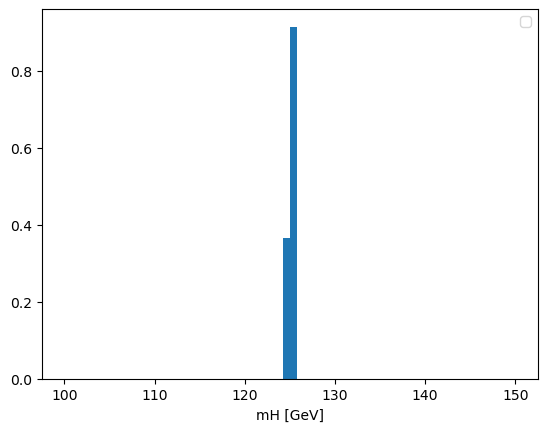

In [16]:
fig, ax = plt.subplots()
ax.hist(np.sqrt(result), density=True, bins=64, range=(100, 150))
ax.set_xlabel("mH [GeV]")
ax.legend()

In [22]:
def p4_invmass(p4:np.ndarray):
    return p4[0]**2 - (p4[1]**2 + p4[2]**2 + p4[3]**2)

In [28]:
reader = IOIMPL.LCFactory.getInstance().createLCReader()
reader.open(osp.abspath("zh.slcio"))

n_events = 1000  # reader.getNumberOfEvents()
result = np.zeros(n_events, dtype=np.float64)

for i_event in (pbar := tqdm(range(n_events))):
    event = reader.readNextEvent()
    pbar.set_description(f'Processing event {event.getEventNumber()}')

    # Iterate through the MCParticle collection and find muon and anti muon
    # see page 5 on https://pdg.lbl.gov/2019/reviews/rpp2019-rev-monte-carlo-numbering.pdf
    mc_particles = event.getCollection('MCParticlesSkimmed')
    
    # Fill the 4-momentum of the initial electron and positron
    p4_CM = np.zeros(4, dtype=np.float64)
    for i in range(2):
        mc_particle = mc_particles[i]
        mom = mc_particle.getMomentum()
        E = mc_particle.getEnergy()
        p4_CM += np.array([E, mom[0], mom[1], mom[2]])
    
    # Fill the 4-momentum of the Z boson and the photon
    p4_Z = np.zeros(4, dtype=np.float64)
    p4_gamma = np.zeros(4, dtype=np.float64)    
    
    n_muons = 0
    i_particle = 2
    i_max = len(mc_particles)

    while (n_muons != 2) and i_particle < i_max:
        mc_particle = mc_particles[i_particle]
        pdg = abs(mc_particle.getPDG())
        
        if pdg in [13, 22]:
            mom = mc_particle.getMomentum()
            E = mc_particle.getEnergy()
            
            pX = mom[0]
            pY = mom[1]
            pZ = mom[2]
            
            target = p4_Z if pdg == 13 else p4_gamma
            target += np.array([E, pX, pY, pZ])
        
            if pdg == 13:
                n_muons += 1
                
        i_particle += 1
                
    mH = sqrt(p4_invmass(p4_CM - p4_Z - p4_gamma))
    result[i_event] = mH
        
    # break

reader.close()
result = np.array(result)

  0%|          | 0/1000 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


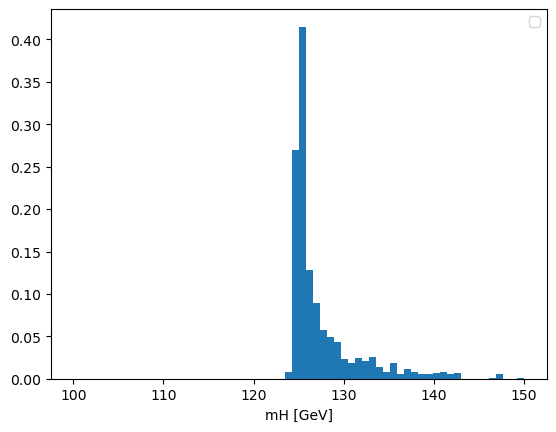

In [29]:
fig, ax = plt.subplots()
ax.hist(result, density=True, bins=64, range=(100, 150))
ax.set_xlabel("mH [GeV]")
ax.legend()